## Importing the libraries

In [1]:
import re
import os
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from google.colab import drive
from skimage.io import imread
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as ks 

## Reading the dataset

In [2]:
arr=[]
labels = []
i=0
j=0
drive.mount('/content/drive')
for root,di,files in os.walk("/content/drive/MyDrive/Colab Notebooks/dataset"): 
  for name in files:
    if name.endswith("pgm"):
      root_folder = os.path.split(root)
      res=re.findall('(\d+)',root_folder[1])
      image = imread(os.path.join(root,name))
      image=image.flatten(order='C')
      arr.append(image)
      labels.append(int(res[0]))
      i=i+1
arr = np.array(arr)   
labels = np.array(labels)    

Mounted at /content/drive


## Exploring the dataset

In [4]:
# adding the data to a dataframe
df = pd.DataFrame(arr) 
df['label'] = pd.DataFrame(labels)
# sorting the data according to labels
df.sort_values("label", inplace=True)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,label
306,48,49,45,47,49,57,39,42,53,49,...,44,40,41,49,42,44,47,46,46,1
308,42,41,44,46,48,39,37,37,33,37,...,33,39,39,40,41,43,42,43,41,1
309,44,43,32,32,30,30,38,40,48,66,...,42,42,40,33,29,37,43,43,37,1
300,64,76,80,53,34,72,60,66,66,50,...,28,34,32,35,34,35,35,37,39,1
301,34,34,33,32,38,40,39,49,54,57,...,44,38,30,37,30,36,37,40,33,1


In [5]:
# seperating images from labels
Y = np.array(df['label'])
df = df.drop(axis=1, labels="label")

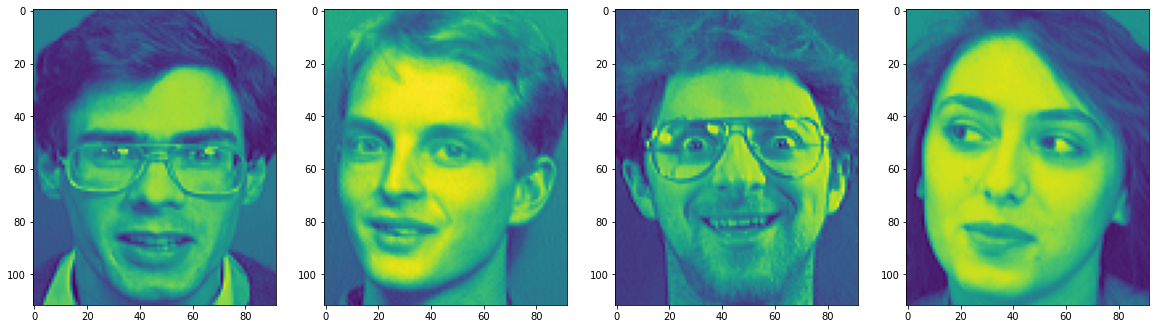

In [60]:
# exploring random images
idx = [np.random.randint(0, 399) for i in range(4)]
plt.figure(figsize=(20, 20))
for i in range(1, 5):
  plt.subplot(1, 4, i)
  img = Image.fromarray(arr[idx[i-1]].reshape((112, 92)))
  plt.imshow(img);

In [9]:
# creating the data matrix D
D = [[] for i in range(40)]
for i in range(0, 400): D[i//10].append(df.iloc[i])
D = np.array(D)
print(D.shape)

(40, 10, 10304)


In [10]:
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  

for i in range(0,400):
    if((i%2==0)):
       X_test.append(arr[i,:])
       labels_test.append(labels[i])
    else:
       X_train.append(arr[i,:])
       labels_train.append(labels[i])
 
print(X_test[0])
print(labels_test[0])

[112 115 120 ...  53  53  54]
4


## Implementing the K nearest neighbor from scratch

In [11]:
def KNN(X_train, X_test, y_train, k):   
  # predicted label
  yPredicted = []
  for i in range(len(X_test)):
    # measuring the distance between that test point each train point
    dist = dict([(j, np.sqrt(np.sum((X_test[i] - X_train[j])**2))) for j in range(len(X_train))])
    # sorting the distances
    dist = sorted(dist.items(), key=lambda kv:(kv[1], kv[0]))
    # considering only the k closest points
    dist = dict(dist[:k])
    # print(dist)
    # creating a counter object to track the labels of k closest neighbors
    counter = Counter([y_train[k] for k in dist.keys()])
    # getting the most common label of all the nearest neighbors
    yPredicted.append(counter.most_common()[0][0])
    # print(counter.most_common()[0][0])
  return yPredicted

In [12]:
def PCA(X):
  # X           ---> data to be reduced
  # alpha       ---> total variance threshold
  # evectors    ---> eigen vectors used to reduce the dimensionality

  # calculate the mean
  mean = np.mean(X,axis=0)
  # center the data
  z = X - mean
  # calculate covariance matrix
  cov = (1/X.shape[0])*np.dot(z.T,z)
  # calculate eigenvalues and eigenvectors
  (evalues, evectors) = np.linalg.eigh(cov)
  evalues = np.flip(evalues)
  evectors = np.flip(evectors,axis=1)

  return (evalues, evectors)

In [13]:
def choose_dim(evalues, evectors, alpha):
  # fraction of total variance
  fr = evalues/evalues.sum()

  totvar = 0
  i = 0

  while(totvar < alpha):
    totvar = totvar + fr[i]
    i = i + 1

  # choose dimensionality
  evectors = evectors[ : , 0:i]

  return evectors

In [14]:
def reduce_dim(X, evectors):
  reducedmat = np.matmul(evectors.T,X.T).T
  return reducedmat

In [27]:
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
(evalues, evectors) = PCA(arr)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES

In [28]:
# saving the PCA output for later use
file_name = 'PCA_output.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(evalues, file)
    print(f'PCA eigen values successfully saved to "{file_name}"')
    pickle.dump(evectors, file)
    print(f'PCA eigen vectors successfully saved to "{file_name}"')

PCA eigen values successfully saved to "PCA_output.pkl"
PCA eigen vectors successfully saved to "PCA_output.pkl"


In [64]:
file_name = 'PCA_output.pkl'
with open(file_name, 'rb') as file:
    evalues  = pickle.load(file)
    print(f'PCA eigen values successfully loaded from "{file_name}"')
    evectors  = pickle.load(file)
    print(f'PCA eigen vectors loaded from "{file_name}"')

PCA eigen values successfully loaded from "PCA_output.pkl"
PCA eigen vectors loaded from "PCA_output.pkl"


In [15]:
def LDA(D):
    # initializing the variables
    summ, lenn = 0, 0
    # computing the mean for each class
    mu = []
    for x in D: 
        mu.append(np.mean(x, axis=0, keepdims=True).T)
        # calculating the sum and overall number
        # elements for overall mu
        summ += np.sum(x, axis=0)
        lenn += len(x)
    mu = np.array(mu)
    overallMu = np.array(summ / lenn).reshape(mu[0].shape)
    # computing the between class scatter matrices
    SB = 0
    for i in range(len(mu)): SB += len(D[i]) * np.matmul((mu[i]-overallMu), (mu[i]-overallMu).T)
    # centering the class matrices
    Z = np.array([D[i] - mu[i].T for i in range(len(D))])
    # computing the within class scatter matrices
    S = 0
    for i in range(len(Z)): S += np.matmul(Z[i].T, Z[i])
    # performing eigenvalue decomposition
    eigValues, eigVectors = np.linalg.eigh(np.matmul(np.linalg.inv(S), SB))
    idx = eigValues.argsort()[::-1]   
    eigValues = eigValues[idx]
    eigVectors = eigVectors[:,idx]
    # returning the dominant eigen vectors
    return eigVectors.T

In [16]:
def KDA(D, kernel_fun, noOfDims):
    # initializing the variables
    summ, lenn = 0, 0
    # computing the n*n kernel matrix
    kMat = kernel_fun(D.reshape((D.shape[2], D.shape[0] * D.shape[1])))
    # seperating each class kernel matrix
    K = []
    start = 0
    for i in range(len(D)-1):
        end = start + len(D[i])
        K.append(kMat[start:end])
        start = end
    K.append(kMat[start:])
    K = np.array(K)
    # computing the mean for each class
    mu = []
    for k in K: 
        mu.append(np.mean(k, axis=0, keepdims=True).T)
        # calculating the sum and overall number
        # elements for overall mu
        summ += np.sum(k, axis=0)
        lenn += len(k)
    mu = np.array(mu)
    overallMu = np.array(summ / lenn).reshape(mu[0].shape)
    # computing the between class scatter matrices
    M = 0
    for i in range(len(mu)): M += len(K[i]) * np.matmul((mu[i]-overallMu), (mu[i]-overallMu).T)
    # centering the class matrices
    Z = np.array([K[i] - mu[i].T for i in range(len(K))])
    # computing the within class scatter matrices
    N = 0
    for i in range(len(Z)): N += np.matmul(Z[i].T, Z[i])
    # regularization to avoid singularity matrix
    N += np.diag(np.full(len(N), 0.001))
    # performing eigenvalue decomposition
    eigValues, a = np.linalg.eigh(np.matmul(np.linalg.inv(N), M))
    # normalizing W to be a unit vector
    a = a / np.linalg.norm(a)
    return kMat, a[::-1][:noOfDims].T

In [17]:
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
lda_eigVectors = LDA(D)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES

In [ ]:
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES
X_kernel, W_kernel = KDA(D, rbf_kernel, 39)
print(X_kernel.shape, W_kernel.shape)
# DO NOT RUN THIS CELL IF YOU ALREADY HAVE THE PICKLE FILES

(400, 400) (400, 39)


In [36]:
# saving the LDA output for later use
file_name = 'LDA_output.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(lda_eigVectors, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "LDA_output.pkl"


In [37]:
file_name = 'LDA_output.pkl'
with open(file_name, 'rb') as file:
    lda_eigVectors = pickle.load(file)
    print(f'LDA eigen vectors successfully loaded from "{file_name}"')
W = lda_eigVectors[:39]
W = W.T

LDA eigen vectors successfully loaded from "LDA_output.pkl"


In [19]:
def projectData(X_train, X_test, W):
    X_train = np.array([np.matmul(W.T, X_train[i]) for i in range(X_train.shape[0])])
    X_test = np.array([np.matmul(W.T, X_test[i]) for i in range(X_test.shape[0])])
    return X_train, X_test

In [20]:
# before reducing the data
print("Before Reduction")
yhat = KNN(X_train, X_test, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

Before Reduction
Testing Set Accuracy: 96.0


In [21]:
# after reducing with PCA with r = 0.8
print("After PCA with r = 0.8")
evectors_red = choose_dim(evalues, evectors, 0.8)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.85
print("After PCA with r = 0.85")
evectors_red = choose_dim(evalues, evectors, 0.85)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.9
print("After PCA with r = 0.9")
evectors_red = choose_dim(evalues, evectors, 0.9)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.95
print("After PCA with r = 0.95")
evectors_red = choose_dim(evalues, evectors, 0.95)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

After PCA with r = 0.8


NameError: ignored

In [38]:
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), W)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

After LDA
Testing Set Accuracy: 94.5


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_kernel, Y,
                                         test_size=0.5, random_state=0, shuffle=True)
print("After KDA")
X_train_kernal, X_test_kernal = projectData(np.array(X_train2), np.array(X_test2), W_kernel)
model = ks(n_neighbors=1).fit(X_train_kernal, y_train2)
train_score = model.score(X_train_kernal, y_train2)
test_score = model.score(X_test_kernal, y_test2)
print("Training Set Accuracy: {}\nTesting  Set Accuracy: {}".format(train_score, test_score))

In [42]:
def KMC(X, k, epsilon=0.01, maxIter=100):
  # initializing the error to be max at first
  err = float('inf')
  # randomly initializing the centroids
  centroid = [X[np.random.randint(0, len(X)-1)] for i in range(k)]
  while maxIter > 0 and err >= epsilon:
    maxIter -= 1
    cluster = [[] for i in range(k)]
    # copying the old centroids
    oldCentroid = copy.deepcopy(centroid)
    # assigning each data point to closest cluster
    for x in X:
      minn, j = float('inf'), 0
      for i in range(len(centroid)):
        dist = np.linalg.norm(x-centroid[i]) ** 2
        if dist < minn: minn, j = dist, i
      cluster[j].append(x)
    # updating the centroids
    for i in range(len(cluster)):
      if len(cluster[i]) != 0: centroid[i] = sum(cluster[i]) / len(cluster[i])
    # if centroids didn't change, then terminate
    err = 0
    for i in range(len(centroid)):
      err += np.linalg.norm(centroid[i] - oldCentroid[i]) ** 2
  return cluster

## Performing a 70%-30% split

In [61]:
X_train = []
X_test =  []  
labels_train = []
labels_test =  []  

for i in range(0, 400, 10):
  for j in range(7):
    X_train.append(arr[i+j, :])
    labels_train.append(labels[i])
  for j in range(7, 10):
    X_test.append(arr[i+j, :])
    labels_test.append(labels[i])
 
print(len(X_train), len(X_test))

280 120


In [62]:
# before reducing the data
print("Before Reduction")
yhat = KNN(X_train, X_test, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

Before Reduction
Testing Set Accuracy: 100.0


In [63]:
# after reducing with PCA with r = 0.8
print("After PCA with r = 0.8")
evectors_red = choose_dim(evalues, evectors, 0.8)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.85
print("After PCA with r = 0.85")
evectors_red = choose_dim(evalues, evectors, 0.85)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.9
print("After PCA with r = 0.9")
evectors_red = choose_dim(evalues, evectors, 0.9)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}\n\n")

# after reducing with PCA with r = 0.95
print("After PCA with r = 0.95")
evectors_red = choose_dim(evalues, evectors, 0.95)
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), evectors_red)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

After PCA with r = 0.8


NameError: ignored

In [64]:
print("After LDA")
X_train_red, X_test_red = projectData(np.array(X_train), np.array(X_test), W)
yhat = KNN(X_train_red, X_test_red, labels_train, 1)
test_score = accuracy_score(labels_test, yhat) * 100
print(f"Testing Set Accuracy: {test_score}")

After LDA
Testing Set Accuracy: 99.16666666666667


#### As we can see the accuracy changed dramatically after changing the ratio of the split